In [1]:
!pip install "numpy==1.26.4"
!pip install "pmdarima==2.0.4"

  Using cached pmdarima-2.0.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
Using cached pmdarima-2.0.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (2.3 MB)


# Aprendizaje Automático (clase 3)

## Diego Fernando Agudelo - Daniel Felipe Osorio
## Universidad ICESI
## diegoagudelo30@gmail.com - dfosorio@icesi.edu.co

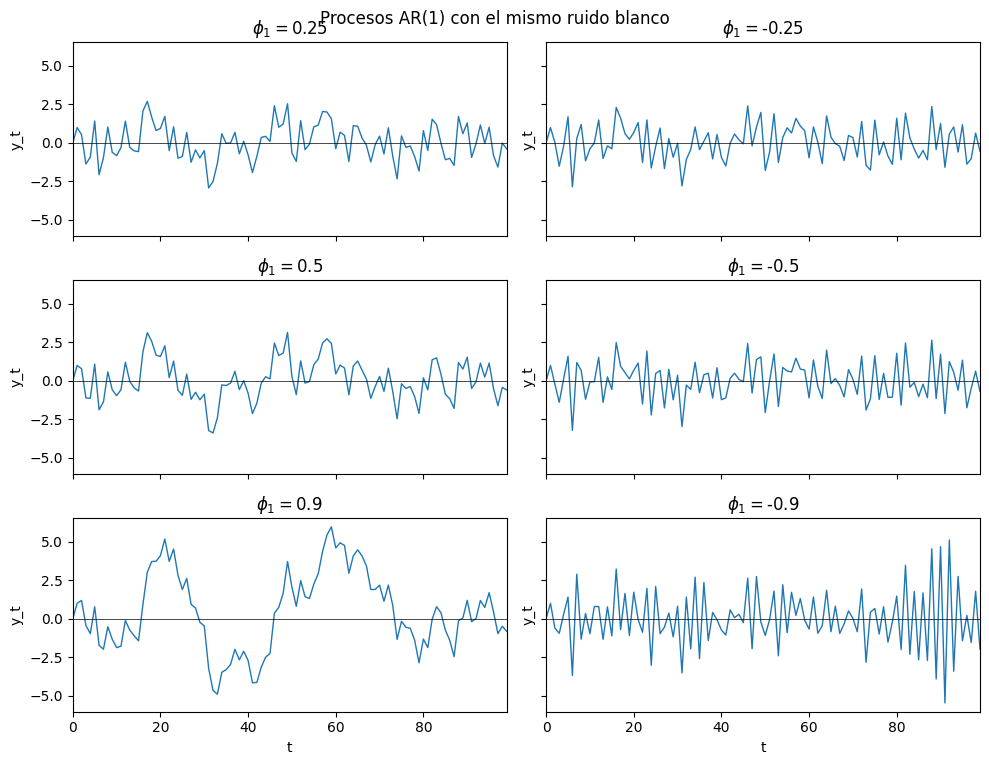

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# reproducibilidad
np.random.seed(123)

T = 100               # número de observaciones
phis = [0.25, -0.25, 0.5, -0.5, 0.9, -0.9]
sigma_eps = 1         # desviación estándar del ruido
eps = np.random.normal(0, sigma_eps, T)   # mismos eps para todos

def sim_ar1(phi, eps):
    y = np.zeros_like(eps)
    for t in range(1, len(eps)):
        y[t] = phi * y[t-1] + eps[t]
    return y

series = [sim_ar1(phi, eps) for phi in phis]

# graficar
fig, axes = plt.subplots(3, 2, figsize=(10, 8), sharex=True, sharey=True)
axes = axes.ravel()

for i, (phi, y) in enumerate(zip(phis, series)):
    axes[i].plot(y, linewidth=1)
    axes[i].set_title(r"$\phi_1 = $" + f"{phi}")
    axes[i].set_xlim(0, T-1)
    axes[i].axhline(0, color='black', linewidth=0.5)
    if i >= 4:  # últimas filas muestran eje x
        axes[i].set_xlabel("t")
    axes[i].set_ylabel("y_t")

plt.suptitle("Procesos AR(1) con el mismo ruido blanco", y=0.95)
plt.tight_layout()
plt.show()

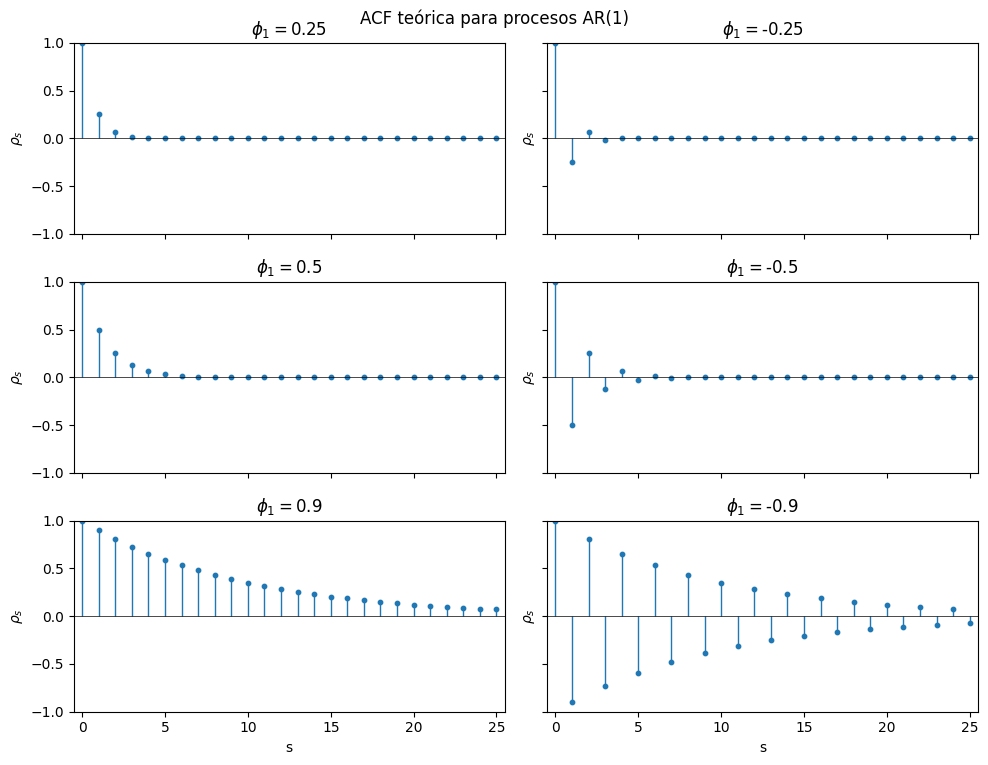

In [ ]:
max_lag = 25

fig, axes = plt.subplots(3, 2, figsize=(10, 8), sharex=True, sharey=True)
axes = axes.ravel()

for i, phi in enumerate(phis):
    lags = np.arange(0, max_lag + 1)
    acf = phi ** lags   # rho_s = phi^s

    ax = axes[i]
    # dibujar como palitos
    ax.vlines(lags, 0, acf, linewidth=1)
    ax.scatter(lags, acf, s=10)

    ax.set_title(r"$\phi_1 = $" + f"{phi}")
    ax.set_xlim(-0.5, max_lag + 0.5)
    ax.set_ylim(-1, 1)
    ax.axhline(0, color="black", linewidth=0.5)

    if i >= 4:
        ax.set_xlabel("s")
    ax.set_ylabel(r"$\rho_s$")

plt.suptitle("ACF teórica para procesos AR(1)", y=0.95)
plt.tight_layout()
plt.show()

## **1. Carga de paquetes**

In [2]:
#!pip install pmdarima
from pmdarima.arima import auto_arima
from pmdarima.utils import acf,pacf
from pmdarima.arima import ARIMA
import pandas as pd
import numpy as np
from statsmodels.sandbox.stats.runs import runstest_1samp # prueba de rachas de Wald y Wolfowitz
import statsmodels.api as sm # prueba de Box-Pierce y la modificación de Ljung-Box
from matplotlib import pyplot as plt # gráficos
import pylab as py
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

import warnings
warnings.filterwarnings("ignore")

## **2. Carga de datos**

Vamos a usar unos datos simulados de un proceso ARIMA(0,1,1)

In [ ]:
data = pd.read_excel("datosEmpleo.xlsx", index_col='mes')
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


In [ ]:
data['Ocupados'].sort_values(ascending=False)

,Ocupados
mes,
2015-11-01,11037.199
2018-09-01,10984.928
2016-10-01,10969.571
2016-11-01,10967.308
2018-07-01,10959.197
...,...
2001-06-01,7014.100
2001-05-01,6994.462
2001-04-01,6973.079


In [ ]:
data['Ocupados'].describe()

,Ocupados
count,222.000000
mean,9160.852009
std,1295.492800
min,6923.604000
25%,7971.103000
50%,9139.064500
75%,10458.510250
max,11037.199000


<Axes: xlabel='mes'>

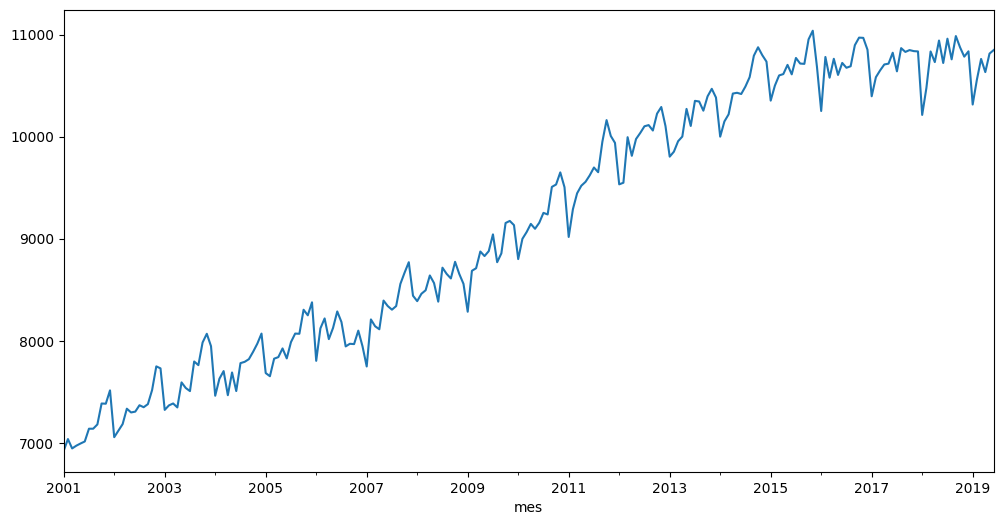

In [ ]:
data['Ocupados'].plot(figsize=(12,6))

In [ ]:
data.shape

(222, 4)

## **3. ACF y PACF**

In [ ]:
acf(data['Ocupados'],40)

array([1.        , 0.97855484, 0.96290943, 0.94999592, 0.93767278,
       0.92828634, 0.91803512, 0.90827078, 0.89628125, 0.88592368,
       0.8772359 , 0.8728291 , 0.86780346, 0.84936325, 0.83206921,
       0.81773834, 0.80588679, 0.79695724, 0.78708534, 0.77639894,
       0.76345987, 0.75177965, 0.74296472, 0.73663393, 0.73128083,
       0.71333785, 0.69520217, 0.68008434, 0.66685076, 0.65659735,
       0.64390143, 0.63170587, 0.6184013 , 0.60541159, 0.59596135,
       0.58936238, 0.5824738 , 0.56326155, 0.54546119, 0.53051481,
       0.51728811])

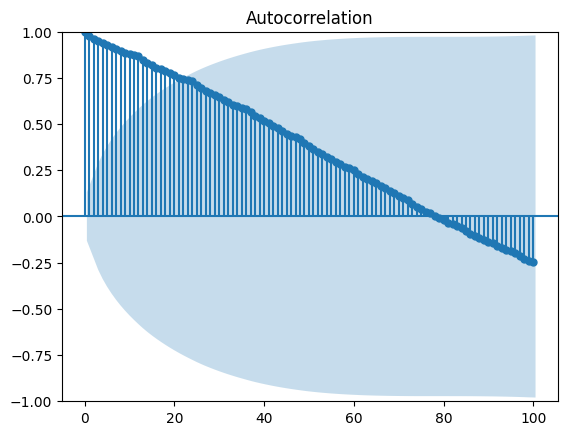

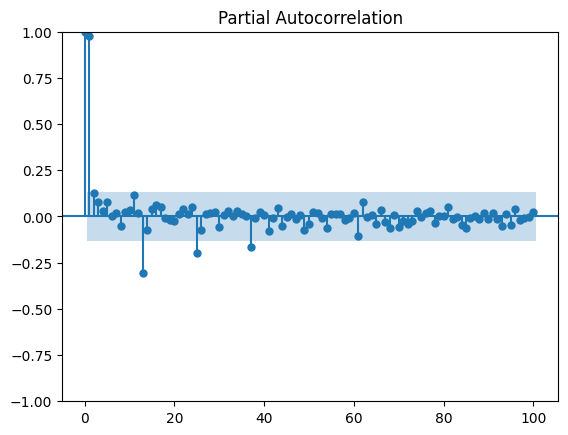

In [ ]:
plot_acf(data['Ocupados'],lags=100);
plot_pacf(data['Ocupados'],lags=100);

In [ ]:
data["Ocupados"].head(10)
data["Ocupados"].diff().head(10)


,Ocupados
mes,
2001-01-01,NaN
2001-02-01,114.142
2001-03-01,-91.773
2001-04-01,27.106
2001-05-01,21.383
2001-06-01,19.638
2001-07-01,125.017
2001-08-01,0.021
2001-09-01,41.987


In [ ]:
data["Ocupados"].diff().min()


-621.7179999999989

In [ ]:
data["Ocupados"].diff().max()

528.9120000000003

In [ ]:
from pmdarima.arima.utils import ndiffs

nd = ndiffs(data["Ocupados"])
nd

1

In [ ]:
data["Ocupados"].iloc[0] = data["Ocupados"].iloc[1]


In [ ]:
data["Ocupados"][:-12]

,Ocupados
mes,
2001-01-01,7037.746
2001-02-01,7037.746
2001-03-01,6945.973
2001-04-01,6973.079
2001-05-01,6994.462
...,...
2018-02-01,10476.311
2018-03-01,10833.980
2018-04-01,10729.977


In [ ]:
## information_criterion (‘aic’, ‘aicc’, ‘bic’, ‘hqic’, ‘oob’)
model = auto_arima(
    data["Ocupados"][:-12],
    #d=1,
    max_p=10,
    max_q=10,
    information_criterion = ("aic"),
    #information_criterion = ("bic"),
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2785.843, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2778.024, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2769.326, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2785.672, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2748.172, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2749.151, Time=0.40 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2749.311, Time=0.39 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2750.045, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2771.129, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2764.927, Time=0.11 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 3.287 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  210
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1370.086
Date:                Sun, 16 Nov 2025   AIC                           2748.172
Time:                        21:58:48   BIC                           2761.541
Sample:                    01-01-2001   HQIC                          2753.577
                         - 06-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     10.1040      2.372      4.260      0.000       5.455      14.753
ar.L1          0.4538      0.097      4.668      0.000       0.263       0.644
ma.L1         -0.8741      0.050    -17.561      0.000      -0.972      -0.776
sigma2       2.88e+04   2499.773     11.521      0.000    2.39e+04    3.37e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                48.26
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               1.31   Skew:                            -0.94
Prob(H) (two-sided):                  0.27   Kurtosis:                         4.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
model.resid()

,0
mes,
2001-01-01,7019.248863
2001-02-01,43.866543
2001-03-01,-70.439519
2001-04-01,4.521861
2001-05-01,2.597648
...,...
2018-02-01,-52.196772
2018-03-01,182.288146
2018-04-01,-117.070831


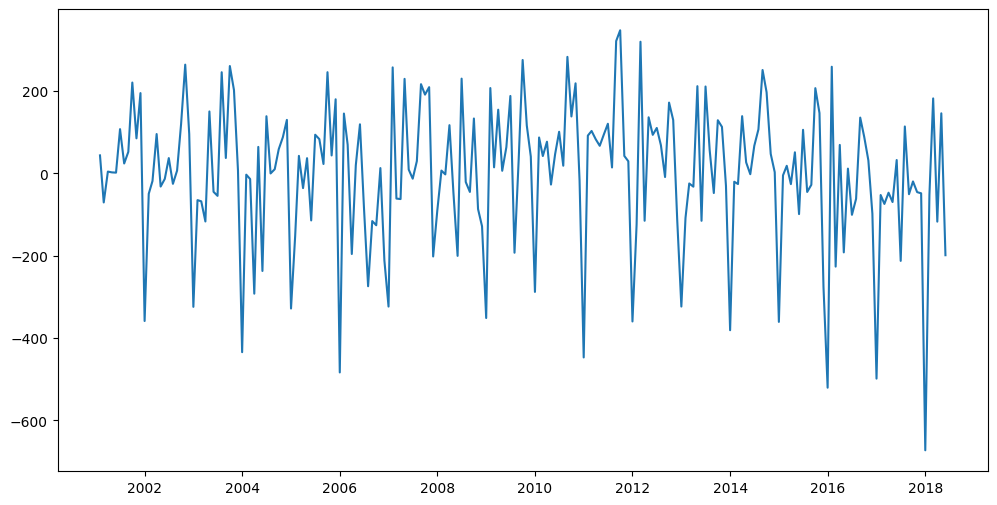

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(model.resid()[1:],label="Residuales")

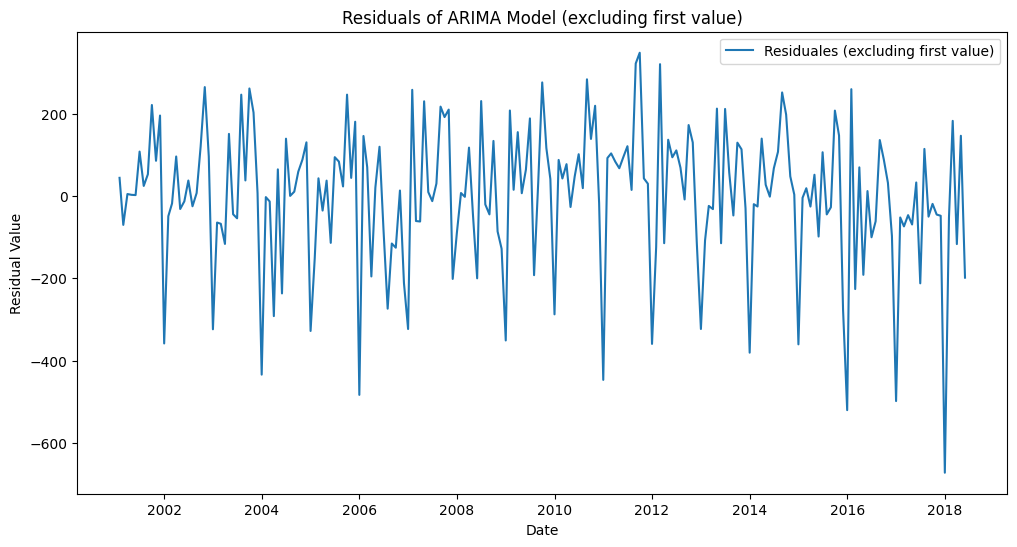

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(model.resid()[1:],label="Residuales (excluding first value)") # Plotting from the second residual
plt.title("Residuals of ARIMA Model (excluding first value)")
plt.xlabel("Date")
plt.ylabel("Residual Value")
plt.legend()
plt.show()

## **4. Pronóstico del ARIMA(1,1,1) obtenido en el auto.arima**


In [ ]:
h=12

y_forec, conf_int  = model.predict(h,return_conf_int=True,alpha=0.05)
preds = pd.DataFrame(np.column_stack([y_forec.values,conf_int[:,0] , conf_int[:,1]]), index=y_forec.index)
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']

preds

,Point_forecast,lower_95,upper_95
2018-07-01,10804.703472,10472.089132,11137.317811
2018-08-01,10852.812657,10468.351326,11237.273988
2018-09-01,10884.746339,10479.098149,11290.394529
2018-10-01,10909.340343,10491.404030,11327.276657
2018-11-01,10930.603950,10503.598223,11357.609677
2018-12-01,10950.356380,10515.621302,11385.091457
2019-01-01,10969.423109,10527.581966,11411.264251
2019-02-01,10988.178700,10539.556931,11436.800468
2019-03-01,11006.793110,10551.585846,11462.000375
2019-04-01,11025.343461,10563.686537,11487.000384


In [ ]:
model.fittedvalues()

,0
mes,
2001-01-01,18.497137
2001-02-01,6993.879457
2001-03-01,7016.412519
2001-04-01,6968.557139
2001-05-01,6991.864352
...,...
2018-02-01,10528.507772
2018-03-01,10651.691854
2018-04-01,10847.047831


In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
data[210:]

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2018-07-01,10.125100,10959.197,1234.638,5984.340
2018-08-01,10.085244,10756.782,1206.529,6235.352
2018-09-01,10.476567,10984.928,1285.522,5948.622
2018-10-01,10.230811,10874.338,1239.326,6125.791
2018-11-01,9.844539,10783.299,1177.484,6298.992
2018-12-01,10.725865,10835.398,1301.822,6142.856
2019-01-01,13.739328,10314.438,1642.851,6343.066
2019-02-01,12.427409,10557.917,1498.272,6264.403
2019-03-01,11.975098,10760.776,1463.919,6116.140


In [ ]:
rmse = np.sqrt(mean_squared_error(data[:-12]['Ocupados'],model.fittedvalues()))
print(rmse)

513.1727008840885


In [ ]:
rmse = np.sqrt(mean_squared_error(data[210:]['Ocupados'],preds['Point_forecast']))
print(rmse)

289.8091583751167


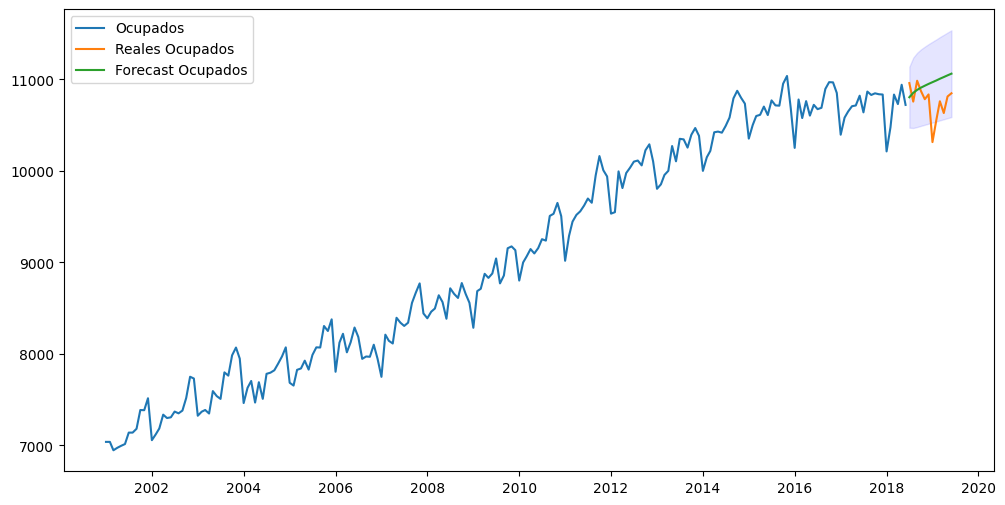

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(data.index[:-12],data[:-12]["Ocupados"],label="Ocupados")
plt.plot(data.index[210:],data[210:]["Ocupados"],label="Reales Ocupados")
plt.plot(preds.index,preds['Point_forecast'],label="Forecast Ocupados")
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

## **Auto Arima con 6 meses**

Influye en el forecast a largo plazo

Con d = 0 → previsiones tienden a una media.

Con d = 1 → previsiones tienden a una línea (tendencia lineal).

Con d = 2 → previsiones se vuelven parabólicas (casi nunca es deseado).

Tu serie es I(1): integrada de orden 1.

Es decir:

Con d=0 → queda no estacionaria, los residuales del modelo serán malos.

Con d=1 → se transforma a diferencias mensuales → se estabiliza.

Con d=2 → estaría sobrediferenciada → se vuelve demasiado ruidosa.

In [ ]:
## information_criterion (‘aic’, ‘aicc’, ‘bic’, ‘hqic’, ‘oob’)
model = auto_arima(
    data["Ocupados"][:-6],
    d=3,
    max_p=100,
    max_q=100,
    information_criterion = ("aic"),
    # information_criterion = ("bic"),
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=2.69 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=3269.737, Time=0.09 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=3141.039, Time=0.09 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=inf, Time=0.47 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=3075.531, Time=0.22 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=3045.035, Time=0.19 sec
 ARIMA(4,3,0)(0,0,0)[0]             : AIC=3002.998, Time=0.17 sec
 ARIMA(5,3,0)(0,0,0)[0]             : AIC=2991.183, Time=0.43 sec
 ARIMA(6,3,0)(0,0,0)[0]             : AIC=2962.777, Time=0.63 sec
 ARIMA(7,3,0)(0,0,0)[0]             : AIC=2948.587, Time=0.73 sec
 ARIMA(8,3,0)(0,0,0)[0]             : AIC=2925.920, Time=0.65 sec
 ARIMA(9,3,0)(0,0,0)[0]             : AIC=2925.396, Time=0.39 sec
 ARIMA(10,3,0)(0,0,0)[0]             : AIC=2916.872, Time=0.26 sec
 ARIMA(11,3,0)(0,0,0)[0]             : AIC=2898.627, Time=0.32 sec
 ARIMA(12,3,0)(0,0,0)[0]             : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  216
Model:              SARIMAX(19, 3, 0)   Log Likelihood               -1375.940
Date:                Sun, 16 Nov 2025   AIC                           2791.880
Time:                        22:41:20   BIC                           2859.106
Sample:                    01-01-2001   HQIC                          2819.048
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.3029      0.071    -32.450      0.000      -2.442      -2.164
ar.L2         -3.6348      0.181    -20.034      0.000      -3.990      -3.279
ar.L3         -4.7990      0.325    -14.773      0.000      -5.436      -4.162
ar.L4         -5.7521      0.498    -11.559      0.000      -6.727      -4.777
ar.L5         -6.5186      0.674     -9.667      0.000      -7.840      -5.197
ar.L6         -7.1360      0.829     -8.609      0.000      -8.761      -5.511
ar.L7         -7.4815      0.942     -7.939      0.000      -9.329      -5.634
ar.L8         -7.6326      1.006     -7.584      0.000      -9.605      -5.660
ar.L9         -7.5627      1.023     -7.392      0.000      -9.568      -5.557
ar.L10        -7.4625      1.017     -7.336      0.000      -9.456      -5.469
ar.L11        -7.1623      1.002     -7.147      0.000      -9.126      -5.198
ar.L12        -6.2212      0.979     -6.352      0.000      -8.141      -4.302
ar.L13        -4.9918      0.922     -5.413      0.000      -6.799      -3.184
ar.L14        -3.7379      0.814     -4.591      0.000      -5.334      -2.142
ar.L15        -2.6812      0.666     -4.024      0.000      -3.987      -1.375
ar.L16        -1.8580      0.503     -3.694      0.000      -2.844      -0.872
ar.L17        -1.1305      0.337     -3.356      0.001      -1.791      -0.470
ar.L18        -0.5851      0.190     -3.084      0.002      -0.957      -0.213
ar.L19        -0.2015      0.075     -2.685      0.007      -0.348      -0.054
sigma2      2.102e+04   2436.257      8.627      0.000    1.62e+04    2.58e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 0.63
Prob(Q):                              0.80   Prob(JB):                         0.73
Heteroskedasticity (H):               0.81   Skew:                            -0.13
Prob(H) (two-sided):                  0.38   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

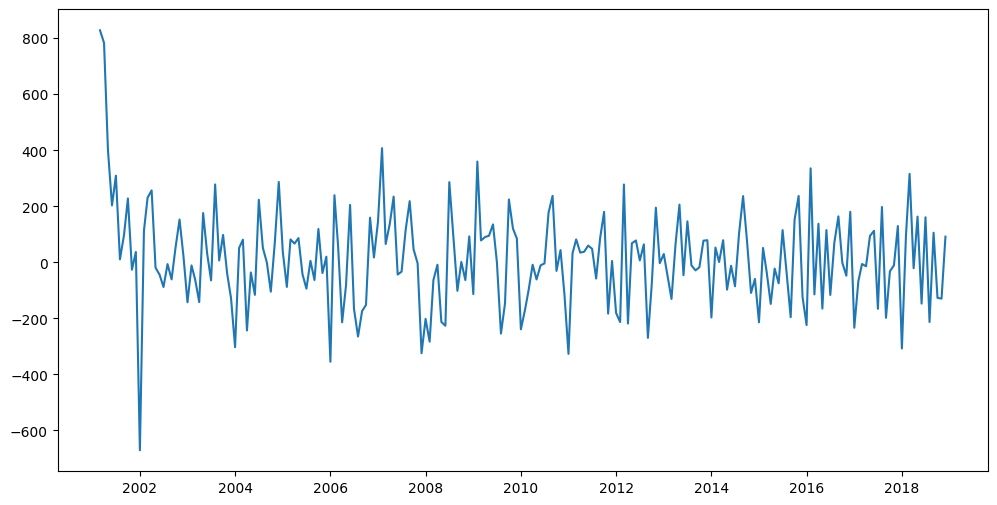

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(model.resid()[2:],label="Residuales")

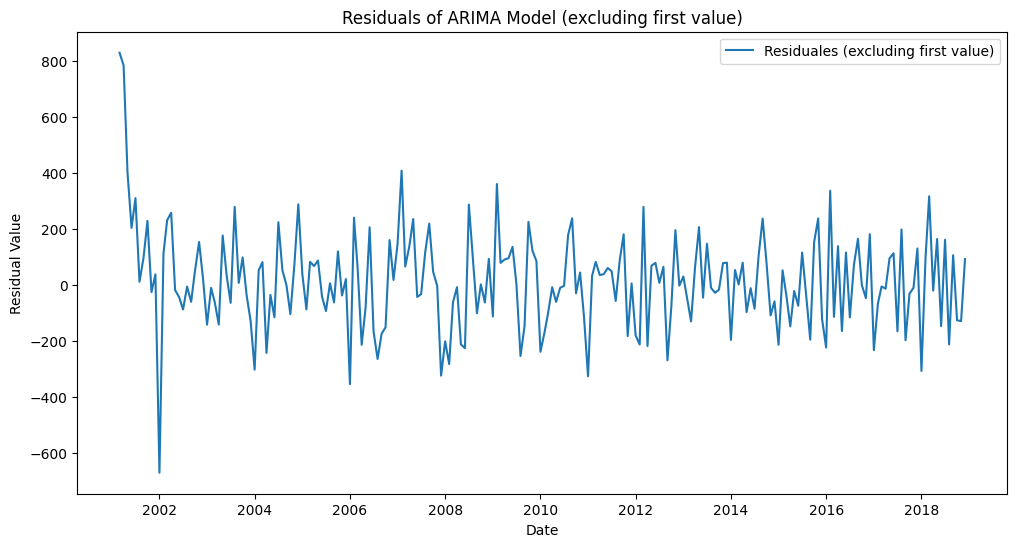

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(model.resid()[2:],label="Residuales (excluding first value)") # Plotting from the second residual
plt.title("Residuals of ARIMA Model (excluding first value)")
plt.xlabel("Date")
plt.ylabel("Residual Value")
plt.legend()
plt.show()

In [ ]:
h=6

y_forec, conf_int  = model.predict(h,return_conf_int=True,alpha=0.05)
preds = pd.DataFrame(np.column_stack([y_forec.values,conf_int[:,0] , conf_int[:,1]]), index=y_forec.index)
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']

preds

,Point_forecast,lower_95,upper_95
2019-01-01,10457.711149,10173.573330,10741.848969
2019-02-01,10639.546489,10293.190178,10985.902799
2019-03-01,10799.353673,10391.207458,11207.499889
2019-04-01,10936.010275,10451.740239,11420.280311
2019-05-01,10937.249708,10371.697392,11502.802024
2019-06-01,10831.956061,10182.567404,11481.344719


In [ ]:
rmse = np.sqrt(mean_squared_error(data[:-6]['Ocupados'],model.fittedvalues()))
print(rmse)

707.4610249230305


In [ ]:
rmse = np.sqrt(mean_squared_error(data[216:]['Ocupados'],preds['Point_forecast']))
print(rmse)

150.9853343042369


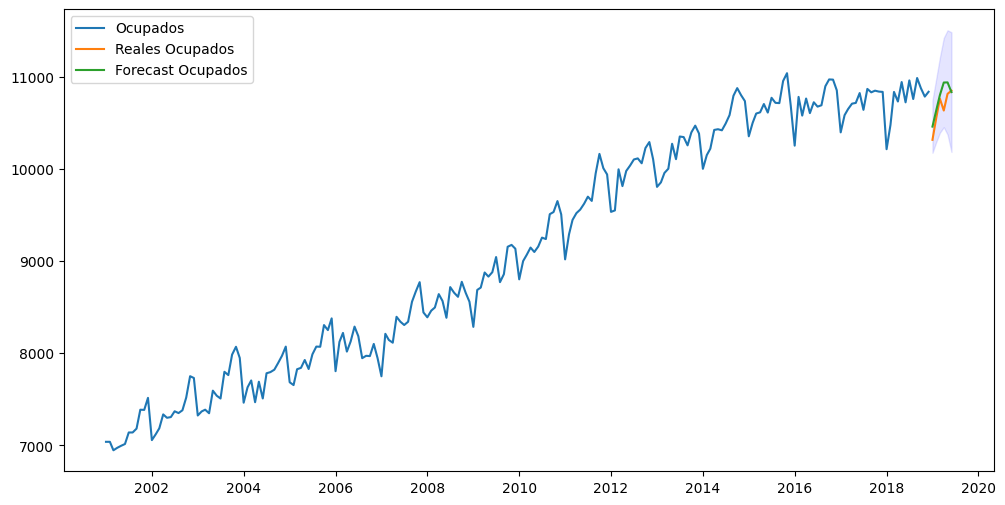

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(data.index[:-6],data[:-6]["Ocupados"],label="Ocupados")
plt.plot(data.index[216:],data[216:]["Ocupados"],label="Reales Ocupados")
plt.plot(preds.index,preds['Point_forecast'],label="Forecast Ocupados")
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

## **5. Replicando el modelo sin hacer auto arima**

---



> Añadir blockquote



In [ ]:
model = ARIMA(order=(1,1,1))
results = model.fit( data[:-6]["Ocupados"])
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  216
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1408.266
Date:                Sun, 16 Nov 2025   AIC                           2824.532
Time:                        22:43:54   BIC                           2838.015
Sample:                    01-01-2001   HQIC                          2829.980
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     10.2122      2.362      4.324      0.000       5.583      14.841
ar.L1          0.4427      0.095      4.654      0.000       0.256       0.629
ma.L1         -0.8712      0.048    -18.082      0.000      -0.966      -0.777
sigma2      2.849e+04   2430.703     11.723      0.000    2.37e+04    3.33e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                47.30
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                            -0.91
Prob(H) (two-sided):                  0.39   Kurtosis:                         4.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

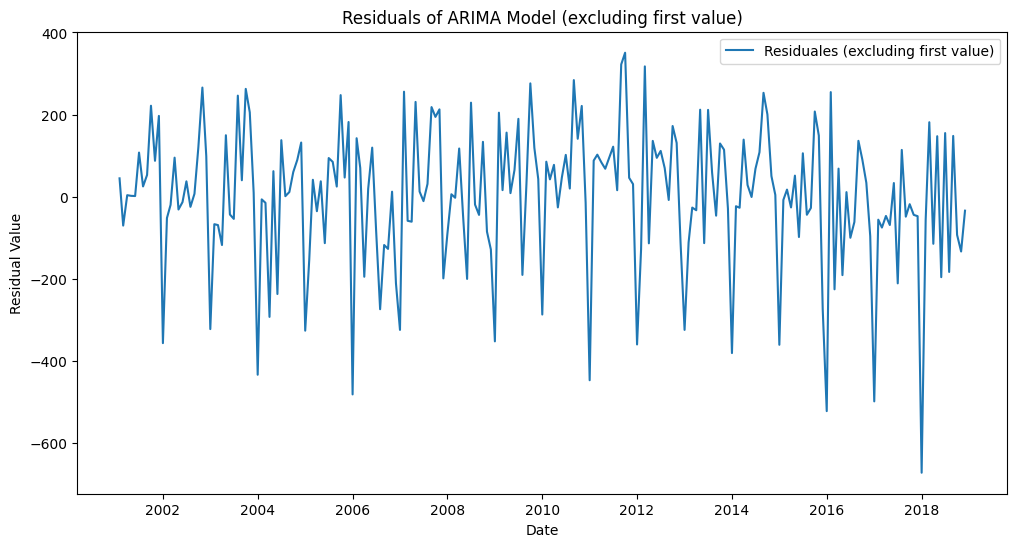

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(model.resid()[1:],label="Residuales (excluding first value)") # Plotting from the second residual
plt.title("Residuals of ARIMA Model (excluding first value)")
plt.xlabel("Date")
plt.ylabel("Residual Value")
plt.legend()
plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(data[:-6]['Ocupados'],model.fittedvalues()))
print(rmse)

506.49718760263653


In [ ]:
rmse = np.sqrt(mean_squared_error(data[216:]['Ocupados'],preds['Point_forecast']))
print(rmse)

150.9853343042369


**correlacion Autocorrelación**

Para determinar si existe autocorrelación vamos a usar la prueba de rachas propuesta por Wald y Wolfowitz, 1940. Es una prueba no paramétrica donde las hipótesis son las siguientes:

$H{0}: ρ = 0$ (Es decir no hay autocorrelación)

$H{1}: ρ \not= 0$ (Es decir hay autocorrelación)

Rechazo $H{0}$ cuando el p-valor es menor al nivel de significancia, convencionalmente se usa un $α$=0.05 ($α$ = nivel de significancia).

In [ ]:
signo = model.resid()>0
runstest_1samp(signo, correction=False)

(-1.3059732030203752, 0.1915616705294627)

In [ ]:
# prueba de Box-Pierce y la modificación de Ljung-Box
sm.stats.acorr_ljungbox(model.resid(), lags=[1], return_df=True,boxpierce=True ) # Se puede hacer para un solo lag.

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,0.013353,0.908004,0.01317,0.908636


In [ ]:
Resul_lb_bp = sm.stats.acorr_ljungbox(model.resid(), lags=range(1,210), return_df=True,boxpierce=True )
Resul_lb_bp["lb_ho"] = np.where(Resul_lb_bp['lb_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')
Resul_lb_bp["bp_ho"] = np.where(Resul_lb_bp['bp_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')

Resul_lb_bp

,lb_stat,lb_pvalue,bp_stat,bp_pvalue,lb_ho,bp_ho
1,0.013353,0.908004,0.013170,0.908636,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
2,0.042306,0.979069,0.041591,0.979419,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
3,0.048148,0.997230,0.047299,0.997303,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
4,0.056831,0.999604,0.055743,0.999619,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
5,0.061065,0.999952,0.059841,0.999954,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
...,...,...,...,...,...,...
205,82.957231,1.000000,16.843805,1.000000,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
206,84.584973,1.000000,16.918472,1.000000,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
207,86.359942,1.000000,16.991750,1.000000,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
208,87.529547,1.000000,17.034672,1.000000,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr


**Homoscedasticidad y Heteroscedasticidad**

Ahora nos queda por chequear si existe problemas de heteroscedasticidad, en
especial un comportamiento tipo ARCH o GARCH, esto implica que la varianza de la serie tenga un comportamiento no autocorrelacionado.

Una aproximación para determinar si existe un comportamiento GARCH o
ARCH es emplear la prueba de Ljung-Box sobre la serie (sin media) al cuadrado.

$H{0}:$ Comportamiento Homoscedastico (Es decir varianza constante)

$H{1}:$ Comportamiento Heteroscedastico (Es decir varianza no constante)

In [ ]:
sm.stats.acorr_ljungbox((model.resid() - model.resid().mean())**2, lags=range(1,210), return_df=True,boxpierce=True )

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,0.000090,0.992419,0.000089,0.992471
2,0.000136,0.999932,0.000134,0.999933
3,0.000235,0.999999,0.000230,0.999999
4,0.000348,1.000000,0.000341,1.000000
5,0.000468,1.000000,0.000456,1.000000
...,...,...,...,...
205,1.908817,1.000000,0.345504,1.000000
206,2.006941,1.000000,0.350005,1.000000
207,2.117180,1.000000,0.354556,1.000000
208,2.252547,1.000000,0.359523,1.000000


**Normalidad**

Finalmente, podemos evaluar si la serie sigue una distribución normal o no. Noten que esto no es necesario para ser ruido blanco, solo para ser ruido blanco gaussiano. Primero hagamos un análisis gráfico empleando las siguientes lineas de código.

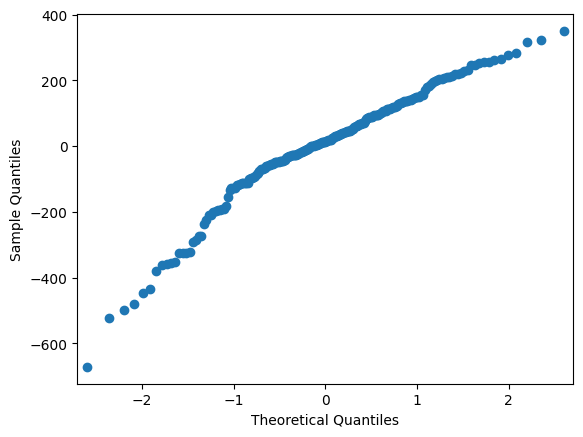

In [ ]:
# sm.qqplot(model.resid()[1:], line ='s') # 45
sm.qqplot(model.resid()[1:]) # 45
py.show()

In [ ]:
model.resid()

,0
mes,
2001-01-01,7019.422746
2001-02-01,44.957178
2001-03-01,-70.023634
2001-04-01,3.987690
2001-05-01,2.350478
...,...
2018-08-01,-182.903232
2018-09-01,148.183960
2018-10-01,-92.691262


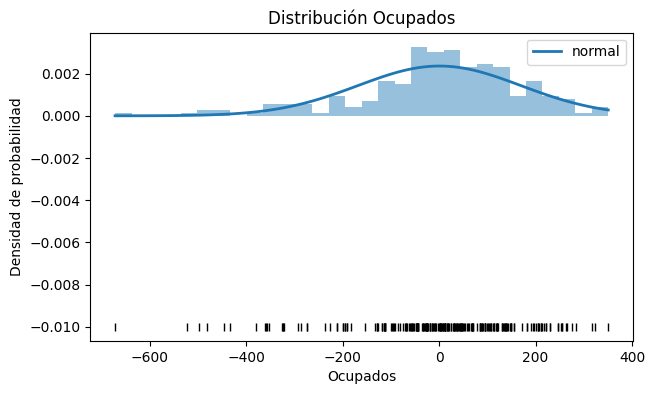

In [ ]:
# Histograma + curva normal teórica
# ==============================================================================

# Valores de la media (mu) y desviación típica (sigma) de los datos
mu, sigma = stats.norm.fit(model.resid()[1:])

# Valores teóricos de la normal en el rango observado
x_hat = np.linspace(min(model.resid()[1:]), max(model.resid()[1:]), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

# Gráfico
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=model.resid()[1:], density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(model.resid()[1:], np.full_like(model.resid()[1:], -0.01), '|k', markeredgewidth=1)
ax.set_title('Distribución Ocupados')
ax.set_xlabel('Ocupados')
ax.set_ylabel('Densidad de probabilidad')
ax.legend();

In [ ]:
from statsmodels.sandbox.stats.runs import runstest_1samp # prueba de rachas de Wald y Wolfowitz
import statsmodels.api as sm # prueba de Box-Pierce y la modificación de Ljung-Box
from matplotlib import pyplot as plt # gráficos
import pylab as py
from scipy import stats

In [ ]:
stats.shapiro(model.resid())

ShapiroResult(statistic=0.26146211435737987, pvalue=1.6016551642414032e-28)

In [ ]:
stats.jarque_bera(model.resid())

SignificanceResult(statistic=253604.99921638233, pvalue=0.0)

No hay normalidad

## **6. Intervalos de confianza usando boostrap**


In [ ]:
h= 6
res = results.resid()

my_samples = []
for _ in range(1000):

    x = np.random.choice(res, size=h, replace=True)
    my_samples.append(x)

q1=np.quantile(my_samples,0.025,axis=0)
q2=np.quantile(my_samples,0.975,axis=0)

fore = results.predict(h,return_conf_int=False)

preds = pd.DataFrame(np.column_stack([fore,fore+np.cumsum(q1) , fore+np.cumsum(q2)]), index=y_forec.index)
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']

preds


,Point_forecast,lower_95,upper_95
2019-01-01,10898.062817,10464.951132,11164.004456
2019-02-01,10936.014566,10021.892297,11486.060184
2019-03-01,10963.026685,9668.526541,11775.803106
2019-04-01,10985.196203,9257.584373,12082.076601
2019-05-01,11005.222067,8897.232362,12419.567625
2019-06-01,11024.299008,8482.862944,12701.455641


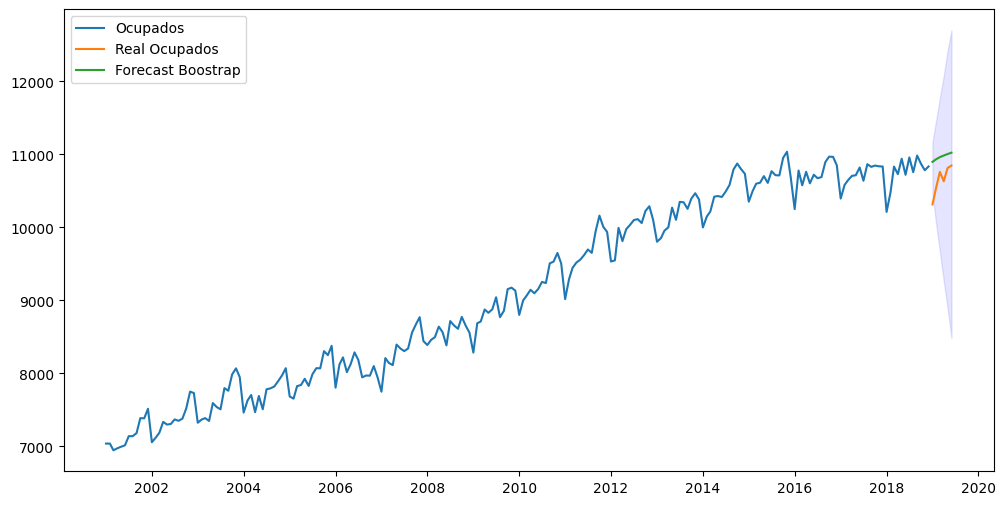

In [ ]:
x_for= np.linspace((data.shape[0]+1),(data.shape[0]+h),h)

fig = plt.figure(figsize=(12, 6))
plt.plot(data.index[:-6],data["Ocupados"][:-6],label="Ocupados")
plt.plot(data.index[216:],data["Ocupados"][216:],label="Real Ocupados")
plt.plot(preds.index,preds['Point_forecast'],label="Forecast Boostrap")
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

### **7. Ejercicio en Clase**

Empleando la información del número de ocupados en miles de personas (Ocupados) para las 13 principales ciudades, encuentre el mejor pronóstico para los próximos 6 meses empleando los métodos vistos en la clase. Compare
los resultados con el mejor modelo encontrado en el ejercicio anterior.

Escriba un breve informe de máximo una página de texto que explique cómo llega a sus proyeccciones y presente las proyecciones. Aclare en el texto cuáles serían las limitaciones de sus pronósticos.

In [ ]:
model = ARIMA(order=(1,1,1))
results = model.fit( data["Ocupados"])
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  222
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1451.152
Date:                Sun, 16 Nov 2025   AIC                           2910.305
Time:                        22:46:13   BIC                           2923.898
Sample:                    01-01-2001   HQIC                          2915.793
                         - 06-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.8137      2.465      3.982      0.000       4.983      14.644
ar.L1          0.4401      0.101      4.369      0.000       0.243       0.637
ma.L1         -0.8624      0.052    -16.576      0.000      -0.964      -0.760
sigma2      2.944e+04   2472.248     11.909      0.000    2.46e+04    3.43e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                57.38
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               1.31   Skew:                            -0.98
Prob(H) (two-sided):                  0.25   Kurtosis:                         4.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

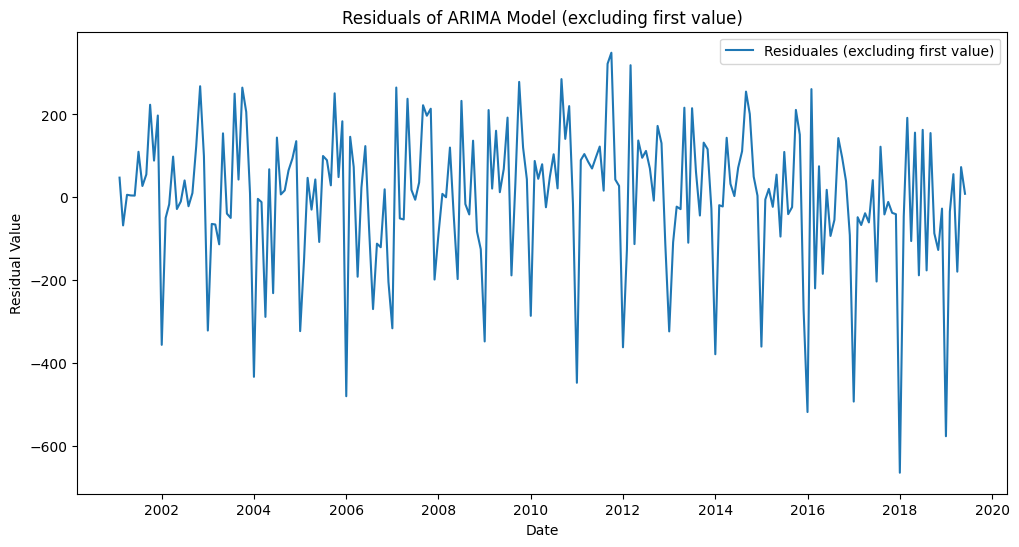

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(model.resid()[1:],label="Residuales (excluding first value)") # Plotting from the second residual
plt.title("Residuals of ARIMA Model (excluding first value)")
plt.xlabel("Date")
plt.ylabel("Residual Value")
plt.legend()
plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(data['Ocupados'],model.fittedvalues()))
print(rmse)

501.3698205410526


In [ ]:
fitted_values = model.fittedvalues()

# Los valores reales deben coincidir con el período de entrenamiento
# Asegúrate de que 'data' contenga la columna de tu variable dependiente.
y_true = data["Ocupados"]

# Calcular los residuos (errores)
residuales = y_true - fitted_values

# Calcular el error cuadrático medio (MSE)
mse = np.mean(residuales ** 2)

# Calcular la raíz cuadrada (RMSE)
rmse = np.sqrt(mse)

print(f"El valor del RMSE es: {rmse}")

El valor del RMSE es: 501.3698205410526


**correlacion Autocorrelación**

Para determinar si existe autocorrelación vamos a usar la prueba de rachas propuesta por Wald y Wolfowitz, 1940. Es una prueba no paramétrica donde las hipótesis son las siguientes:

$H{0}: ρ = 0$ (Es decir no hay autocorrelación)

$H{1}: ρ \not= 0$ (Es decir hay autocorrelación)

Rechazo $H{0}$ cuando el p-valor es menor al nivel de significancia, convencionalmente se usa un $α$=0.05 ($α$ = nivel de significancia).

In [ ]:
signo = model.resid()>0
runstest_1samp(signo, correction=False)

(-1.5359529163397578, 0.12454992846816701)

In [ ]:
# prueba de Box-Pierce y la modificación de Ljung-Box
sm.stats.acorr_ljungbox(model.resid(), lags=[1], return_df=True,boxpierce=True ) # Se puede hacer para un solo lag.

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,0.01338,0.907913,0.013201,0.908529


In [ ]:
Resul_lb_bp = sm.stats.acorr_ljungbox(model.resid(), lags=range(1,222), return_df=True,boxpierce=True )
Resul_lb_bp["lb_ho"] = np.where(Resul_lb_bp['lb_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')
Resul_lb_bp["bp_ho"] = np.where(Resul_lb_bp['bp_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')

Resul_lb_bp

,lb_stat,lb_pvalue,bp_stat,bp_pvalue,lb_ho,bp_ho
1,0.013380,0.907913,0.013201,0.908529,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
2,0.039279,0.980552,0.038638,0.980867,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
3,0.040797,0.997835,0.040121,0.997888,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
4,0.058661,0.999578,0.057507,0.999594,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
5,0.067515,0.999938,0.066084,0.999942,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
...,...,...,...,...,...,...
217,127.201980,1.000000,18.405381,1.000000,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
218,127.300704,1.000000,18.407144,1.000000,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
219,139.048110,0.999994,18.564476,1.000000,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
220,139.688550,0.999994,18.570194,1.000000,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr


**Homoscedasticidad y Heteroscedasticidad**

Ahora nos queda por chequear si existe problemas de heteroscedasticidad, en
especial un comportamiento tipo ARCH o GARCH, esto implica que la varianza de la serie tenga un comportamiento no autocorrelacionado.

Una aproximación para determinar si existe un comportamiento GARCH o
ARCH es emplear la prueba de Ljung-Box sobre la serie (sin media) al cuadrado.

$H{0}:$ Comportamiento Homoscedastico (Es decir varianza constante)

$H{1}:$ Comportamiento Heteroscedastico (Es decir varianza no constante)

In [ ]:
sm.stats.acorr_ljungbox((model.resid() - model.resid().mean())**2, lags=range(1,210), return_df=True,boxpierce=True )

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,0.000099,0.992046,0.000098,0.992099
2,0.000154,0.999923,0.000151,0.999924
3,0.000260,0.999999,0.000256,0.999999
4,0.000385,1.000000,0.000377,1.000000
5,0.000516,1.000000,0.000503,1.000000
...,...,...,...,...
205,1.515595,1.000000,0.329082,1.000000
206,1.573132,1.000000,0.333192,1.000000
207,1.638720,1.000000,0.337584,1.000000
208,1.712529,1.000000,0.342197,1.000000


**Normalidad**

Finalmente, podemos evaluar si la serie sigue una distribución normal o no. Noten que esto no es necesario para ser ruido blanco, solo para ser ruido blanco gaussiano. Primero hagamos un análisis gráfico empleando las siguientes lineas de código.

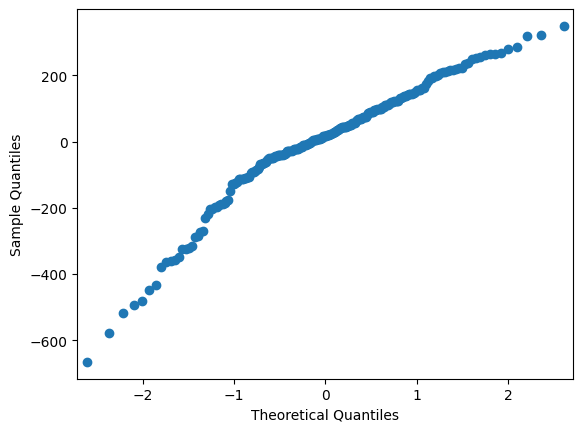

In [ ]:
# sm.qqplot(model.resid()[1:], line ='s') # 45
sm.qqplot(model.resid()[1:]) # 45
py.show()

In [ ]:
model.resid()

,0
mes,
2001-01-01,7020.219796
2001-02-01,47.313534
2001-03-01,-68.092528
2001-04-01,5.858283
2001-05-01,4.287089
...,...
2019-02-01,-35.007204
2019-03-01,55.711508
2019-04-01,-179.786190


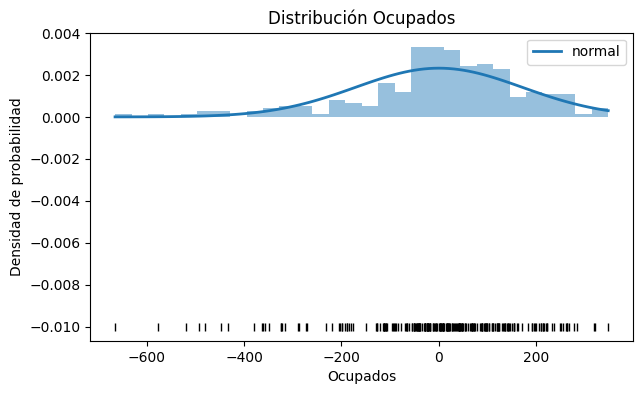

In [ ]:
# Histograma + curva normal teórica
# ==============================================================================

# Valores de la media (mu) y desviación típica (sigma) de los datos
mu, sigma = stats.norm.fit(model.resid()[1:])

# Valores teóricos de la normal en el rango observado
x_hat = np.linspace(min(model.resid()[1:]), max(model.resid()[1:]), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

# Gráfico
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=model.resid()[1:], density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(model.resid()[1:], np.full_like(model.resid()[1:], -0.01), '|k', markeredgewidth=1)
ax.set_title('Distribución Ocupados')
ax.set_xlabel('Ocupados')
ax.set_ylabel('Densidad de probabilidad')
ax.legend();

In [ ]:
stats.shapiro(model.resid())

ShapiroResult(statistic=0.2663932556138128, pvalue=8.680086740360144e-29)

In [ ]:
stats.jarque_bera(model.resid())

SignificanceResult(statistic=268076.1899579813, pvalue=0.0)

In [ ]:
model.resid()

,0
mes,
2001-01-01,7020.219796
2001-02-01,47.313534
2001-03-01,-68.092528
2001-04-01,5.858283
2001-05-01,4.287089
...,...
2019-02-01,-35.007204
2019-03-01,55.711508
2019-04-01,-179.786190


In [ ]:
h= 6
res = model.resid()

my_samples = []
for _ in range(1000):

    x = np.random.choice(res, size=h, replace=True)
    my_samples.append(x)

q1=np.quantile(my_samples,0.025,axis=0)
q2=np.quantile(my_samples,0.975,axis=0)

fore = model.predict(h,return_conf_int=False)

preds = pd.DataFrame(np.column_stack([fore,fore+np.cumsum(q1) , fore+np.cumsum(q2)]), index=fore.index)
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']

preds

,Point_forecast,lower_95,upper_95
2019-07-01,10866.054220,10431.838406,11134.177830
2019-08-01,10883.812780,9968.865706,11437.282242
2019-09-01,10901.441234,9624.004866,11740.256547
2019-10-01,10919.012433,9207.719652,12025.951357
2019-11-01,10936.558437,8777.033230,12311.620972
2019-12-01,10954.093355,8346.335721,12597.279499


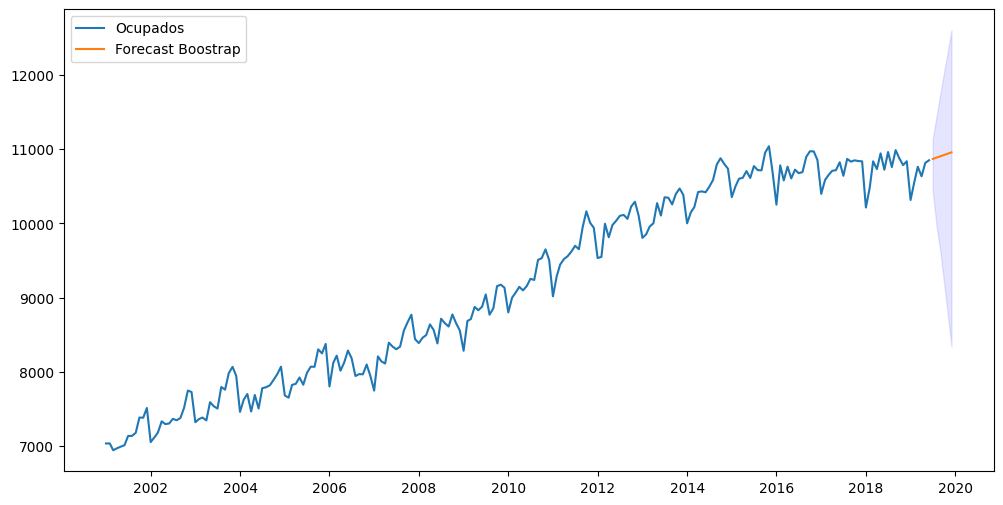

In [ ]:
x_for= np.linspace((data.shape[0]+1),(data.shape[0]+h),h)

fig = plt.figure(figsize=(12, 6))
plt.plot(data.index,data["Ocupados"],label="Ocupados")
#plt.plot(data.index[216:],data["Ocupados"][216:],label="Real Ocupados")
plt.plot(preds.index,preds['Point_forecast'],label="Forecast Boostrap")
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def bootstrap_forecast(model, data, h=6, B=1000, colname="Ocupados"):
    """
    Genera pronósticos tipo ARIMA usando bootstrap de residuos.

    model   → modelo ARIMA ya entrenado
    data    → DataFrame original
    h       → horizonte de pronóstico
    B       → número de simulaciones bootstrap
    colname → nombre de la columna Y real
    """

    # Residuales del modelo
    res = model.resid()

    # Bootstrap: B simulaciones de h pasos
    samples = np.random.choice(res, size=(B, h), replace=True)

    # Cuantiles empíricos 95%
    q_low = np.quantile(samples, 0.025, axis=0)
    q_high = np.quantile(samples, 0.975, axis=0)

    # Pronóstico puntual
    fore = model.predict(h, return_conf_int=False)

    # Intervalos acumulados (ARIMA multipaso)
    lower = fore + np.cumsum(q_low)
    upper = fore + np.cumsum(q_high)

    # DataFrame
    preds = pd.DataFrame({
        "Point_forecast": fore,
        "lower_95": lower,
        "upper_95": upper
    }, index=fore.index)

    # --- Gráfica ---
    plt.figure(figsize=(12,5))

    # Serie histórica
    plt.plot(data.index, data[colname], label="Real", color="black")

    # Pronóstico
    plt.plot(preds.index, preds["Point_forecast"], label="Forecast", linestyle="--")

    # Intervalos
    plt.fill_between(preds.index, preds["lower_95"], preds["upper_95"],
                     alpha=0.3, label="95% Bootstrap CI")

    plt.legend()
    plt.title("Pronóstico ARIMA con intervalos Bootstrap")
    plt.show()

    return preds


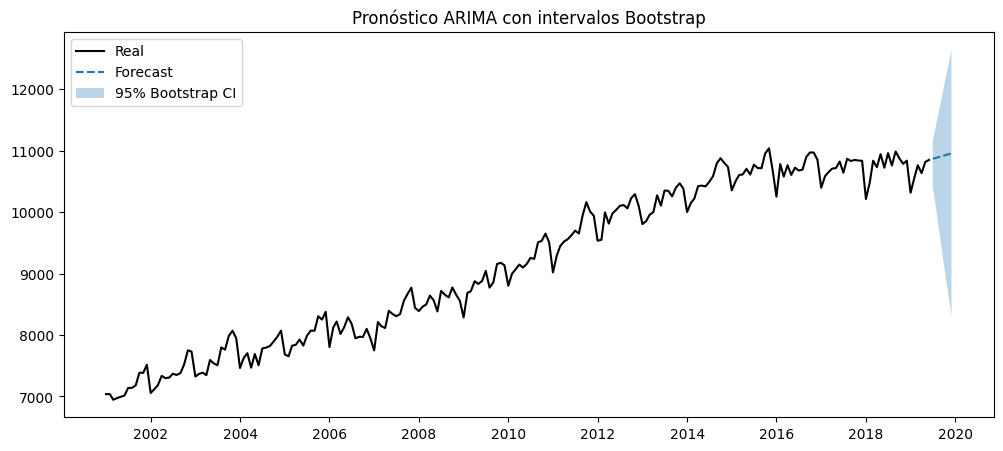

,Point_forecast,lower_95,upper_95
2019-07-01,10866.054220,10417.821794,11144.654957
2019-08-01,10883.812780,10001.364540,11447.759369
2019-09-01,10901.441234,9570.760567,11743.988560
2019-10-01,10919.012433,9140.099340,12046.905610
2019-11-01,10936.558437,8723.788931,12343.052352
2019-12-01,10954.093355,8307.467435,12639.188007


In [ ]:
preds = bootstrap_forecast(model, data, h=6, B=1000, colname="Ocupados")
preds
